# Переход от сенсоров к источникам   
https://mne.tools/stable/auto_tutorials/source-modeling/plot_forward.html#tut-forward   

Очень подробный вебинар   

https://youtu.be/kuIwPtFwBxw

In [1]:
import os.path as op
import os
import mne

In [2]:
# This code sets an environment variable called SUBJECTS_DIR
os.environ['SUBJECTS_DIR'] = '/net/server/data/Archive/speech_learn/freesurfer'
subjects_dir = '/net/server/data/Archive/speech_learn/freesurfer'

In [3]:
# Испытуемый выбран рандомно, просто в качестве примера 
subject='L008'

In [4]:
# the raw file containing the channel location + types
raw_fname = '/net/server/data/Archive/speech_learn/meg/L008/191220/L008_day1_1_active1_raw_tsss_mc_trans.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True) 

Opening raw data file /net/server/data/Archive/speech_learn/meg/L008/191220/L008_day1_1_active1_raw_tsss_mc_trans.fif...
    Range : 0 ... 996999 =      0.000 ...   996.999 secs
Ready.
Reading 0 ... 996999  =      0.000 ...   996.999 secs...


<ipython-input-4-dc8838c81215>:3: RuntimeWarning: This filename (/net/server/data/Archive/speech_learn/meg/L008/191220/L008_day1_1_active1_raw_tsss_mc_trans.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = raw = mne.io.read_raw_fif(raw_fname, preload=True)


In [5]:
events = mne.find_events(raw = raw, stim_channel='STI101', shortest_event=1)
event_id = {
    'LH': 16,
    'LF': 38,
    'RF': 32,
    'RH': 50
}

490 events found
Event IDs: [  1   9  16  18  32  34  36  38  48  50  52  54  64 100 128]


In [6]:
epochs = mne.Epochs(raw = raw, events = events, event_id=event_id)
evoked = epochs.average()

Not setting metadata
Not setting metadata
97 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


# 1. Прямая задача   

# 1. Head Model: BEM (boundary element model) surface - создается отдельно для каждого испытуемого  

subjects_dir - папка где лежат данные с Freesurfer для каждого испытуемого   
Для построения BEM модели, необходимо задать оболожки мозга. Для МЭГ достаточно одной - внутреняя оболочка черепа (inner skull), которые должны быть заранее сегментированы. По идее все это должно уже быть в папке Freesurfer. После построения BEM модели желательно проверить насколько хорошо прошла сегментаця. Для этого использовать функцию *mne.viz.plot_bem*

In [7]:
conductivity = [0.3] # for single layer
model = mne.make_bem_model(subject='L008', ico=4, conductivity= conductivity, subjects_dir=subjects_dir, verbose=None)

bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is   0.48 -20.71  35.98 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


Using surface: /net/server/data/Archive/speech_learn/freesurfer/L008/bem/inner_skull.surf
Using surface: /net/server/data/Archive/speech_learn/freesurfer/L008/bem/outer_skull.surf
Using surface: /net/server/data/Archive/speech_learn/freesurfer/L008/bem/outer_skin.surf


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/mne/viz/utils.py:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


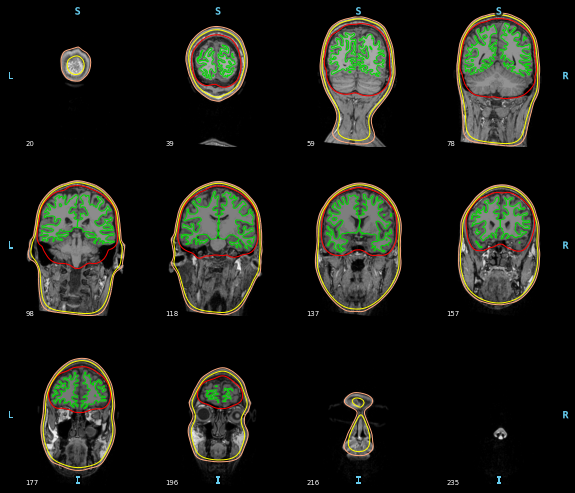

In [8]:
mne.viz.plot_bem(subject, subjects_dir, brain_surfaces='white', orientation='coronal');

# 2. Задаем пространство источников (source space) - src

Для этого есть 2 функции в MNE:  
mne.setup_source_space - источники плоские (вертексы), могут быть расположены на поверхности коры
mne.setup_volume_source_space - исптоники объемные, могут быть расплоложены по всему объему  

Из-за особенностией магнитного сигнала, мы ожидаем, что источники расположены на коре, т.е. используем функцию setup_source_space

In [9]:
src = mne.setup_source_space(subject ='L008', add_dist=False )

Setting up the source space with the following parameters:

SUBJECTS_DIR = /net/server/data/Archive/speech_learn/freesurfer
Subject      = L008
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /net/server/data/Archive/speech_learn/freesurfer/L008/surf/lh.white...
Mapping lh L008 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /net/server/data/Archive/speech_learn/freesurfer/L008/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/166385 selected to source space (oct = 6)

Loading /net/server/data/Archive/speech_learn/freesurfer/L008/surf/rh.white...
Mapping rh L008 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /net/server/data/Archive/speech_learn/freesurfer/L008/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/165074 selected to source sp

In [10]:
src.plot()

Using pyvista 3d backend.



# 3. Корегистрация - осуществляется в MNE Analyzer tool  

Либо уже лежит в папке Freeserfer (часто там уже полный комплект файлов)

# Прописываем путь к папке где лежит файл, полученный в результате корегистрации МЭГ и МРТ.   

Поскольку МЭГ и МРТ использую разные системы координат, то для их совместного использования необходимо привести к "общему знаменателю".

Из конспекта МЭГ:   

"Эта информация записана в файле корегистрации (trans в mne-python), как правило, хранятся в freesurfer/subject_name/mri/T1-neuromag/sets/COR-*-*-*.fif
Для запуска корегистрации нужен любой .fif файл - точки оцифровки никак не затрагиваются обработкой максфильтра  -  и путь к текущей папке с фрисерферами и бемами."

In [11]:
trans = '/net/server/data/Archive/speech_learn/freesurfer/L008/mri/T1-neuromag/sets/COR.fif'

#если нужна функция чтения транс
#trans = mne.read_trans('/net/server/data/Archive/speech_learn/freesurfer/L008/mri/T1-neuromag/sets/COR.fif')

In [12]:
mne.viz.plot_alignment(epochs.info, trans, subject='L008', surfaces=['white', 'outer_skin'])

Using outer_skin.surf for head surface.
Getting helmet for system 306m


In [13]:
# Forward Model
fwd = mne.make_forward_solution(info=epochs.info, trans=trans, src=src, bem=bem)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=166385, n_used=4098>, <surface (rh), n_vertices=165074, n_used=4098>] MRI (surface RAS) coords, subject 'L008', ~25.5 MB>
MRI -> head transform : /net/server/data/Archive/speech_learn/freesurfer/L008/mri/T1-neuromag/sets/COR.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000      -0.00 mm
     0.000000  1.000000  0.000000      -0.00 mm
     0.000000  0.000000  1.000000      -0.00 mm
     0.000000  0.000000  0.000000       1.00

Read 306 MEG channels from info
99 coil definitions read
Coordinate transformation: MEG device -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000

# Обратная задача (Inverse model)   

1. Создание noise covarience (cov), на основе которой получим inverse operator (inv). Для получения cov есть два способа: использование сигнала в пустой комнате и использование baseline. Иногда можно (даже желательно) обходиться без cov, но это отдельная история. В данном примере взять baseline -500 до -100 мс относительно стимула

In [14]:
cov = mne.compute_covariance(epochs=epochs, method='auto', tmin=-0.5, tmax = -0.1)

Loading data for 26 events and 701 original time points ...
0 bad epochs dropped
Loading data for 24 events and 701 original time points ...
0 bad epochs dropped
Loading data for 29 events and 701 original time points ...
0 bad epochs dropped
Loading data for 18 events and 701 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 9.2e-09 (2.2e-16 eps * 306 dim * 1.3e+05  max singular value)
    Estimated rank (mag + grad): 306
    MEG: rank 306 computed from 306 data channels with 0 projectors


<ipython-input-14-e074a2b76929>:1: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  cov = mne.compute_covariance(epochs=epochs, method='auto', tmin=-0.5, tmax = -0.1)


Reducing data rank from 306 -> 306
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
    GRAD regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    GRAD regularization : 0.1
    MAG regularization : 0.1
    GRAD regularization : 0.1
    MAG regularization : 0.1
    GRAD regularization : 0.1
Number of samples used : 9797
log-likelihood on unseen data (descending order):
   shrunk: -664.565
   diagonal_fixed: -1486.711
   empirical: -5196.331
selecting best estimator: shrunk
[done]


In [15]:
inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, loose=0.2)  

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 1665/8196 = 10.016643
    scale = 3.85058e-06 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 8.1e-13 (2.2e-16 eps * 306 dim * 12  max singular value)
    Estimated rank (mag + grad): 306
    MEG: rank 306 computed from 306 data channels with 0 projectors
    Setting small MEG eigenvalues to zero (without PCA)


<ipython-input-15-cac355044727>:1: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, loose=0.2)


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-15-cac355044727>:1: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, loose=0.2)


    largest singular value = 7.1812
    scaling factor to adjust the trace = 2.42662e+23


# stc - отдельно для каждой эпохи

In [16]:
stc = mne.minimum_norm.apply_inverse_epochs(epochs, inv, lambda2=1. / 9., pick_ori='normal')

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 306 (0 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 97 (at most)
Processing epoch : 2 / 97 (at most)
Processing epoch : 3 / 97 (at most)
Processing epoch : 4 / 97 (at most)
Processing epoch : 5 / 97 (at most)
Processing epoch : 6 / 97 (at most)
Processing epoch : 7 / 97 (at most)
Processing epoch : 8 / 97 (at most)
Processing epoch : 9 / 97 (at most)
Processing epoch : 10 / 97 (at most)
Processing epoch : 11 / 97 (at most)
Processing epoch : 12 / 97 (at most)
Processing epoch : 13 / 97 (at most)
Processing epoch : 14 / 97 (at most)
Processing epoch : 15 / 97 (at mos

In [17]:
stc[0].plot() 

Using control points [1.57613662 1.79103753 3.48201994]


# stc - для Evoked

In [16]:
#By default, SNR = 3
snr = 3
lambda2 = 1. / snr ** 2

stc = mne.minimum_norm.apply_inverse(evoked, inv, lambda2)
#stc = mne.apply_inverse_epochs(epochs, inv, method, lambda2, pick_ori='normal')

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 97
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 306 (0 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.27 * LH + 0.25 * LF + 0.30 * RF + 0.19 * RH"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained   3.6% variance
    Combining the current components...
    dSPM...
[done]


In [18]:
stc.plot(hemi='both') 

Using control points [ 3.61628683  4.27150854 10.21476664]


# Морфинг 

Мофинг - сигнал мозговой активности конкретного человека "намазываем" на усредненный мозг. Усредненный мозг предоставляется самим freeserfer в папке fsavarage. Можно использовать его, а можно использовать любой другой мозг (например усредненный по всем испытуемым мозг).  

Когда для всех испытуемых получен сигнал на усреденном мозге, то можно проводить групповой анализ. 



### fsavarage for morphing (speech learn)

/net/server/data/Archive/speech_learn/freesurfer/fsaverage

In [19]:
morph = mne.compute_source_morph(stc, subject_from='L008', subject_to='fsaverage')
stc_fsaverage = morph.apply(stc)

<ipython-input-19-fa5793b261cc>:1: RuntimeWarning: Could not find or make morph map directory "/net/server/data/Archive/speech_learn/freesurfer/morph-maps"
  morph = mne.compute_source_morph(stc, subject_from='L008', subject_to='fsaverage')
<ipython-input-19-fa5793b261cc>:1: RuntimeWarning: Could not write morph-map file "/net/server/data/Archive/speech_learn/freesurfer/morph-maps/fsaverage-L008-morph.fif" (error: [Errno 2] Нет такого файла или каталога: '/net/server/data/Archive/speech_learn/freesurfer/morph-maps/fsaverage-L008-morph.fif')
  morph = mne.compute_source_morph(stc, subject_from='L008', subject_to='fsaverage')


In [21]:
stc_fsaverage.plot(hemi='both')

Using control points [3.66681351 4.30291038 9.94273819]


# Сохраниение stc

In [20]:
stc_fsaverage.save('/home/vtretyakova/Рабочий стол/Sources/test')

Writing STC to disk...
[done]


# Чтение stc   

https://mne.tools/stable/generated/mne.read_source_estimate.html

In [23]:
os.environ['SUBJECTS_DIR'] = '/home/vtretyakova/Рабочий стол/Sources/freesurfer'

In [25]:
stc = mne.read_source_estimate('/home/vtretyakova/Рабочий стол/Sources/test', 'fsaverage')

In [26]:
stc.plot(hemi='both')

Using control points [3.66681355 4.30291026 9.94273823]


# Good luck with your transformation ;)